In [212]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats
from vanguard_analysis import rename_demo_columns,plot_numerical,create_correlation_matrix,experiment_evalutaion,calculate_avg_daily_visits_per_time_period,calculate_time_spent,compare_calls_vs_logons,data_explore

In [213]:
df_demo= pd.read_csv('./Sources/df_final_demo.csv')
df_experiment=pd.read_csv('./Sources/df_final_experiment_clients.csv')
df_pt1= pd.read_csv('./Sources/df_final_web_data_pt_1.csv')
df_pt2= pd.read_csv('./Sources/df_final_web_data_pt_2.csv')

# Cleaning and merging data

In [215]:
#merging df_demo with df_experiment
merged_dfdemo_exp= pd.merge(df_demo,df_experiment, on='client_id', how='left')  

In [216]:
#val=merged_dfdemo_exp[merged_dfdemo_exp['Variation'].isnull()]

In [217]:

# cleaning df_demo merged with EXP  ---- AT THE END WE STILL HAVE Variation with 20107 nulles values
merged_dfdemo_exp_filt= merged_dfdemo_exp.dropna(subset=['clnt_age', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'], how='all')
#replace the null values of clnt_age with mode

mode_age = merged_dfdemo_exp_filt['clnt_age'].mode()
merged_dfdemo_exp_filt['clnt_age'] = merged_dfdemo_exp_filt['clnt_age'].fillna(mode_age[0])



C:\Users\Tanguy\AppData\Local\Temp\ipykernel_24336\1240050793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_dfdemo_exp_filt['clnt_age'] = merged_dfdemo_exp_filt['clnt_age'].fillna(mode_age[0])


In [218]:
#Calling function to rename columns
df_demo = rename_demo_columns(merged_dfdemo_exp_filt)

In [219]:
# Age segmentation
df_demo.loc[:,'age_segment'] = pd.cut(df_demo['age'], bins=[12, 19, 39, 59, 100], labels=['Teenagers','Young Adults','Adults','Seniors'])
age_distribution = df_demo['age_segment'].value_counts()

In [220]:
# Concatenate pt1 & pt2
df_web_data = pd.concat([df_pt1, df_pt2], axis=0)


In [221]:
df_web_data=df_web_data.drop_duplicates() #dropping just 10764 rows

In [222]:
#merging df_web_data with df_demo     (with 744641 rows and 14 col)
merged_gral= pd.merge(df_web_data,df_demo, on='client_id', how='left')  

In [223]:
# Drop missing values-----(still missing values in Variation)
merged_gral = merged_gral.dropna(subset=["tenure_year","age","tenure_month","gender","number_of_accounts","balance","calls_6_month","logons_6_month","Variation","age_segment"], how="all")
#variation null of df_demo become unknow
df_demo['Variation'] = df_demo['Variation'].fillna('unknown')
# Rename column Variation
merged_gral = merged_gral.rename(columns={'Variation': 'variation'})
df_demo = df_demo.rename(columns={'Variation': 'variation'})

In [224]:
web_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'data_time']
cols_demo_numerical = ['tenure_year', 'tenure_month', 'age', 'number_of_accounts', 'balance', 'calls_6_month', 'logons_6_month']
cols_demo_categorical = ['gender', 'client_id','age_segment','variation']

In [225]:
palette = ['#9370DB', '#87CEEB','#B0C4DE','#D8BFD8','#B0E0E6'] 

# Demographique visualization

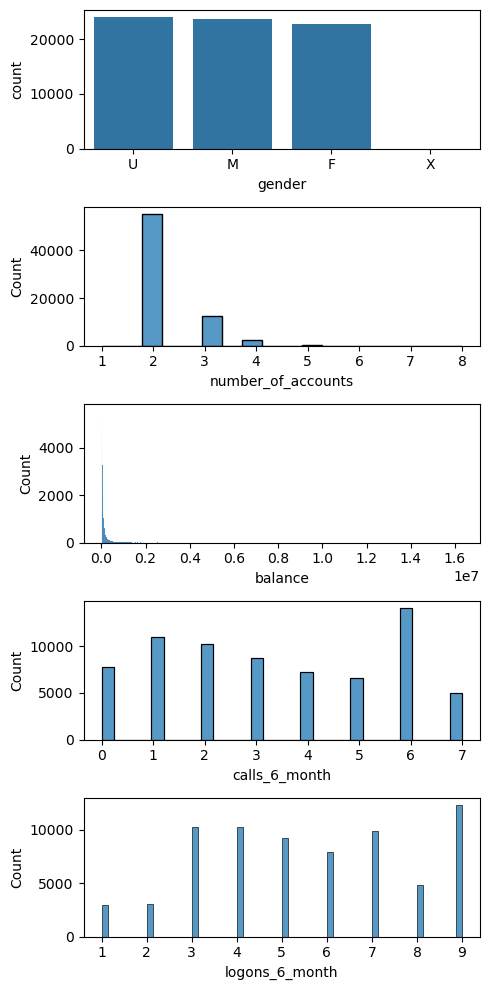

In [227]:
#calling function to create demographique visualizations
plot_numerical(df_demo,['gender', 'number_of_accounts','balance', 'calls_6_month', 'logons_6_month'])

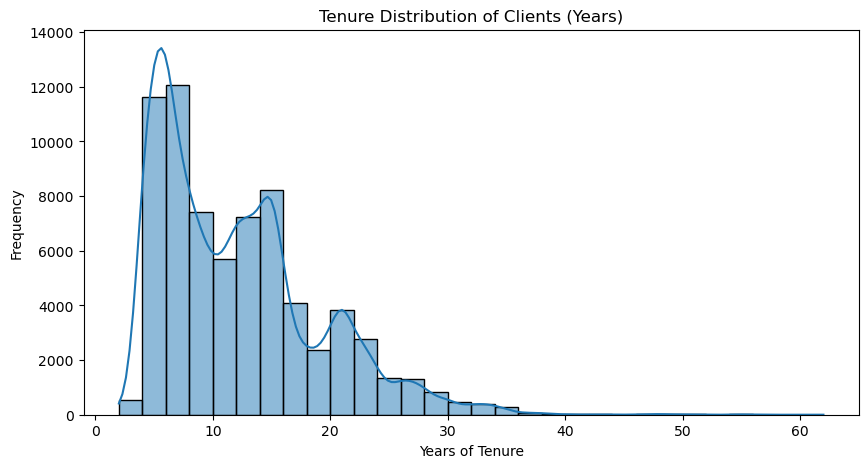

In [228]:
#Analyzing tenure distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_demo['tenure_year'], bins=30, kde=True)
plt.title('Tenure Distribution of Clients (Years)')
plt.xlabel('Years of Tenure')
plt.ylabel('Frequency')
plt.show()

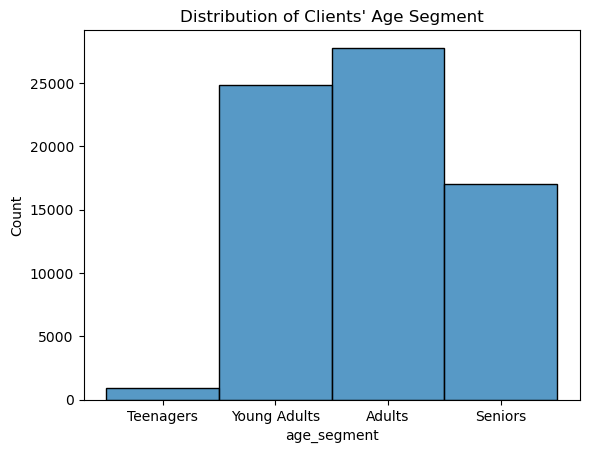

In [229]:
# Distribution of clients' age segment
sns.histplot(df_demo['age_segment'], bins=20)
plt.title("Distribution of Clients' Age Segment")
plt.show()

Tenure (Years and Months): The distribution shows fluctuations in client acquisition, with some years experiencing an increase in new clients, followed by a decline in others.

Age: The age distribution reveals two distinct peaks, possibly linked to client acquisition trends. Overall, there is a wide range of ages with no clear overarching pattern.

Gender: Gender information is missing for about one-third of the clients. Among the remaining two-thirds, there are slightly more female clients than male.

Number of Accounts: The majority of clients have two accounts, with fewer having three, and only a small number holding four or more accounts.

Balance: Most clients have relatively low balances, while a smaller group holds significantly higher balances.

Calls: Most clients made at least one call in the past six months. There is a notable spike at six calls, possibly due to monthly scheduled check-ins. Interestingly, no client made more than seven calls, which is unexpected given the large sample size.

Logins: Most clients logged in at least three times in the past six months, with a relatively even distribution above that. However, there is an unusually low count at eight logins compared to seven and nine. Additionally, no client has logged in more than nine times, which is unusual and requires further investigation, as a gradual decrease would typically be expected.

Average number of accounts per client: 2.2555280118988597


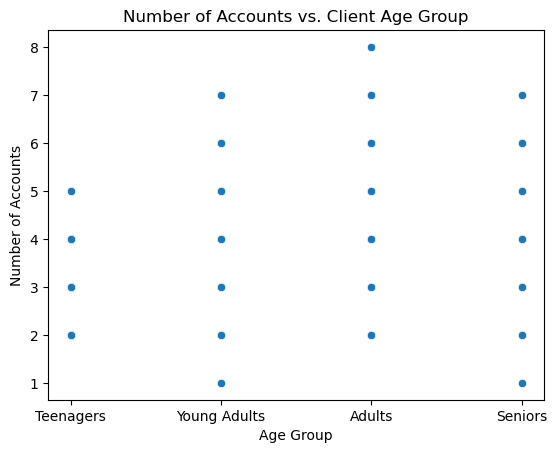

In [231]:
# Average number of accounts
average_accounts = df_demo['number_of_accounts'].mean()
print(f'Average number of accounts per client: {average_accounts}')

# Correlation between age and number of accounts
sns.scatterplot(x='age_segment', y='number_of_accounts', data=df_demo)
plt.title('Number of Accounts vs. Client Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Accounts')
plt.show()

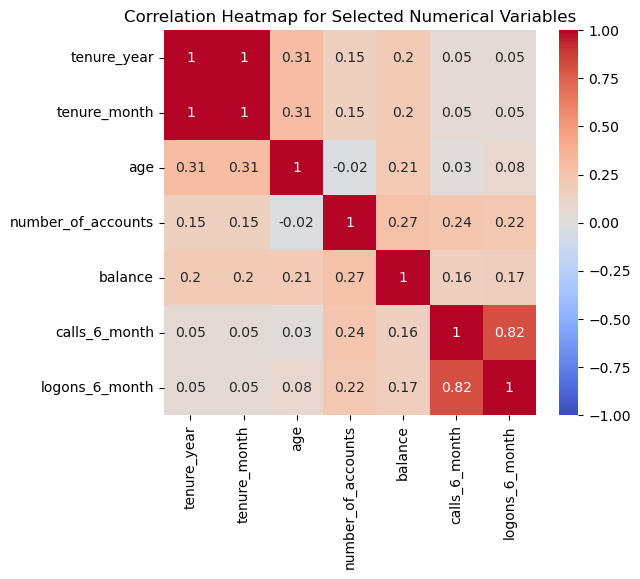

In [232]:
#calling function to create correlation graph
create_correlation_matrix(df_demo, cols_demo_numerical)

--Age and tenure are positively correlated: older clients tend to have been with the company for a longer period.

--The number of logons and calls are highly correlated with each other.

--Balance shows a correlation with all other variables: clients with higher balances are typically older, have been clients for longer, hold more accounts, and have made more calls and logons in the past six months.

# KPIs & Metrics

Bias Test vs Control: 


<Axes: xlabel='bias', ylabel='variable'>

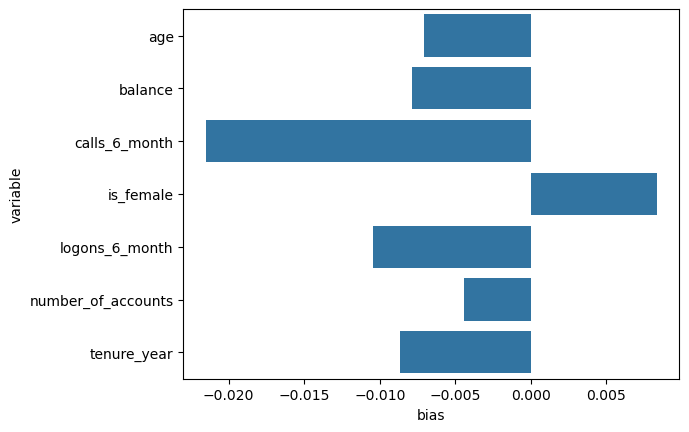

In [235]:
#calling function to create graph biases
# check for bias in the test and control group for the different variables
biases = experiment_evalutaion(df_demo)
sns.barplot(biases, y="variable", x="bias")

In [236]:
merged_gral['date_time'] = pd.to_datetime(merged_gral['date_time'])
# Add extra column indicating the day counting from the start of the trial
merged_gral["day_of_trial"] = merged_gral["date_time"].dt.dayofyear - merged_gral["date_time"].sort_values().dt.dayofyear.iloc[0]
temp_merged_gral=merged_gral.copy()
# Add extra column to identify really unique sessions
temp_merged_gral['unique_session_id'] = temp_merged_gral['client_id'].astype(str) + '_' + temp_merged_gral['visit_id'].astype(str)

<Axes: xlabel='day_of_trial'>

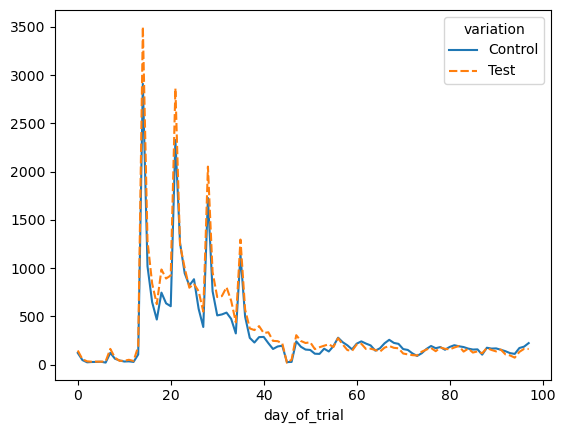

In [237]:
# check number of visits per day for both groups
visits_daily = temp_merged_gral.pivot_table(index="day_of_trial", values="visit_id", columns="variation", aggfunc="nunique")
sns.lineplot(visits_daily)

In [238]:
#calling functions to create average visits
calculate_avg_daily_visits_per_time_period(visits_daily)

Average Daily Visits
--------------------
In the last two weeks of March: 119
In April: 1754
In May and June: 333


Average Daily Visits

In the last two weeks of March: 120
In April: 1755
In May and June: 333

---During the first two weeks, the access rate to the page is relatively low.

---After the first two weeks, the access rate increases significantly, with noticeable spikes on Wednesdays in April. This heightened activity in April is likely due to the approaching deadline for filing federal income tax returns in the U.S.

---In March and June, the access rate decreases again but stabilizes at a level that remains higher than the initial two weeks

C:\Users\Tanguy\AppData\Local\Temp\ipykernel_24336\1299971531.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_process_counts = df_comp_web.groupby(['process_step', 'age_segment']).size().reset_index(name='count')


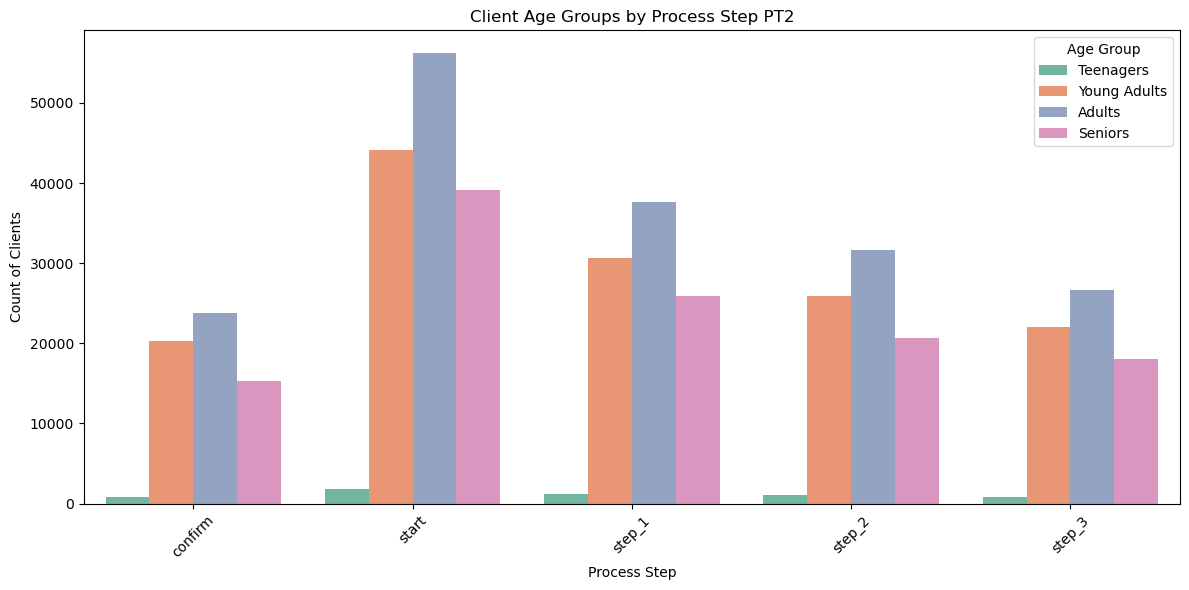

In [241]:
df_comp_web = merged_gral.copy()
df_comp_web_grouped = df_comp_web.groupby('client_id').first()
df_comp_web['age_segment'] = df_comp_web['client_id'].map(df_comp_web_grouped['age_segment'])
# Count clients par age group
age_process_counts = df_comp_web.groupby(['process_step', 'age_segment']).size().reset_index(name='count')

# plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=age_process_counts, x='process_step', y='count', hue='age_segment', palette='Set2')

plt.title('Client Age Groups by Process Step PT2')
plt.xlabel('Process Step')
plt.ylabel('Count of Clients')
plt.legend(title='Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--The completion rate reflects the number of visits that reach the 'confirm' step. This analysis considers the daily completion rate, which will ultimately be summarized by the overall completion rate for the entire test period.

In [243]:
##COMPLETION RATE - WEB DF------
# Convert date_time to datetime and extract the date
merged_gral['date'] = pd.to_datetime(merged_gral['date_time']).dt.date
df_comp_web = merged_gral.copy()
df_comp_web.dropna(subset=["variation"], how="all")
# Calculate completion rate for each group (control vs test) by day, client_id, and visit_id
completion_rate_test = (
    df_comp_web[df_comp_web['process_step'] == 'confirm']
    .groupby(['variation', 'client_id', 'visit_id', 'date']).size()
    .reset_index(name='completion_count')
)

# Calculate total counts for each variation
total_counts = df_comp_web.groupby(['variation', 'client_id', 'visit_id', 'date']).size().reset_index(name='total_count')

# Merge completion counts with total counts
completion_summary = completion_rate_test.merge(total_counts, on=['variation', 'client_id', 'visit_id', 'date'], how='right')

# Calculate completion rate
completion_summary['completion_rate'] = completion_summary['completion_count'] / completion_summary['total_count']

# Calculate the average completion rate across all unique combinations
average_completion_rate_web = completion_summary.groupby('variation')['completion_rate'].mean()

# Display the result
print(average_completion_rate_web)

variation
Control    0.227812
Test       0.322640
Name: completion_rate, dtype: float64


In [244]:
completion_rate_test['client_id'].count()

37878

C:\Users\Tanguy\AppData\Local\Temp\ipykernel_24336\423643356.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variation', y='completion_rate', data=completion_rate_df, palette=palette)
C:\Users\Tanguy\AppData\Local\Temp\ipykernel_24336\423643356.py:5: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x='variation', y='completion_rate', data=completion_rate_df, palette=palette)


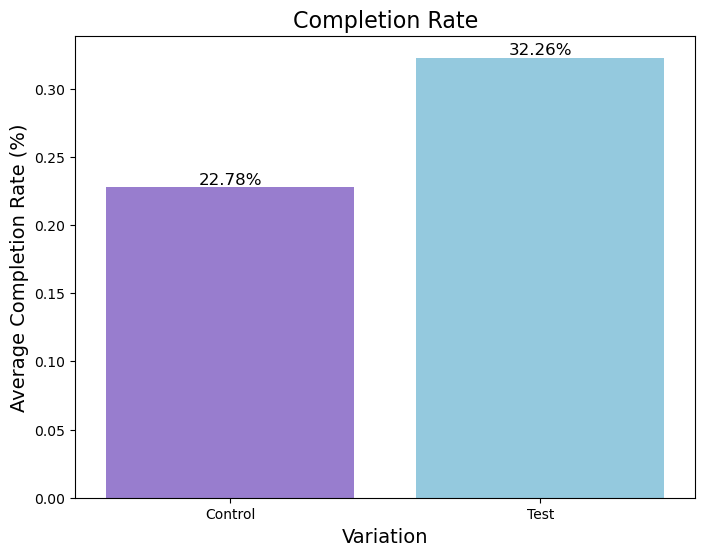

In [245]:
completion_rate_df = average_completion_rate_web.reset_index()

# Create a bar plot 
plt.figure(figsize=(8, 6))
sns.barplot(x='variation', y='completion_rate', data=completion_rate_df, palette=palette)

# Add titles and labels
plt.title('Completion Rate', fontsize=16)
plt.xlabel('Variation', fontsize=14)
plt.ylabel('Average Completion Rate (%)', fontsize=14)

# Add percentages on top of each bar
for index, row in completion_rate_df.iterrows():
    completion_rate_percentage = row['completion_rate'] * 100  # Convert to percentage
    plt.text(index, row['completion_rate'], f'{completion_rate_percentage:.2f}%', color='black', ha="center", va="bottom", fontsize=12)

# Show the plot
plt.show()

In [246]:
##Time rate per Variation on Web DF
# Create a copy of the DataFrame
df_copy_test = merged_gral.copy()

# Ensure the 'date_time' column is in datetime format
df_copy_test['date_time'] = pd.to_datetime(df_copy_test['date_time'])

# Sort the data in the copy
df_copy_test = df_copy_test.sort_values(by=['client_id', 'visit_id', 'date_time'])

# Calculate the time difference in the copy
df_copy_test['time_diff'] = df_copy_test.groupby(['client_id', 'visit_id'])['date_time'].diff()

# Calculate the average time per step for each group in the copy
avg_time_per_step_control_test = df_copy_test[df_copy_test['variation'] == 'Control'].groupby('process_step')['time_diff'].mean()
avg_time_per_step_test_test = df_copy_test[df_copy_test['variation'] == 'Test'].groupby('process_step')['time_diff'].mean()

# Display the results
print("Average time per step for Control group:")
print(avg_time_per_step_control_test)

print("\nAverage time per step for Test group:")
print(avg_time_per_step_test_test)

Average time per step for Control group:
process_step
confirm   0 days 00:02:09.964145590
start     0 days 00:02:54.731609513
step_1    0 days 00:00:43.190358974
step_2    0 days 00:00:38.843287073
step_3    0 days 00:01:34.163321985
Name: time_diff, dtype: timedelta64[ns]

Average time per step for Test group:
process_step
confirm   0 days 00:02:09.491195676
start     0 days 00:02:31.698929939
step_1    0 days 00:00:37.816476665
step_2    0 days 00:00:48.276524400
step_3    0 days 00:01:37.356887825
Name: time_diff, dtype: timedelta64[ns]


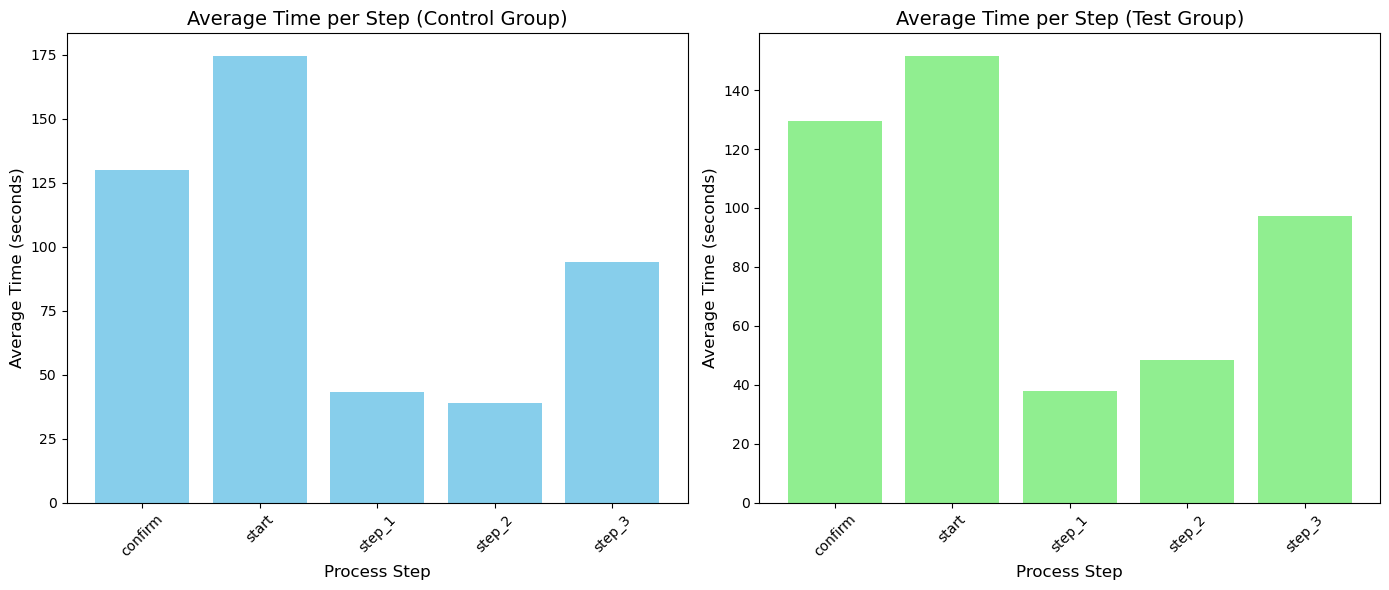

In [247]:
# Convert the time differences to seconds for easier reading
avg_time_per_step_control_test = avg_time_per_step_control_test.dt.total_seconds()
avg_time_per_step_test_test = avg_time_per_step_test_test.dt.total_seconds()

#CReating two graphiques , one next to each other
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First graph -Control group
axes[0].bar(avg_time_per_step_control_test.index, avg_time_per_step_control_test.values, color='skyblue')
axes[0].set_title('Average Time per Step (Control Group)', fontsize=14)
axes[0].set_xlabel('Process Step', fontsize=12)
axes[0].set_ylabel('Average Time (seconds)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Second graph -Test group
axes[1].bar(avg_time_per_step_test_test.index, avg_time_per_step_test_test.values, color='lightgreen')
axes[1].set_title('Average Time per Step (Test Group)', fontsize=14)
axes[1].set_xlabel('Process Step', fontsize=12)
axes[1].set_ylabel('Average Time (seconds)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# plotting
plt.tight_layout()
plt.show()

# HYPOTESES

Hypothesis: The new feature is expected to motivate more clients to complete the process.


In [250]:
# Verify the 5% Threshold
control_success = 0.227812  # Control group success rate 
test_success = 0.322640 # Test group success rate 

# Calculate the differences
difference_test = test_success - control_success

threshold = 0.05  # 5% threshold

# Check the threshold
print(f"Difference in completion rates: {difference_test:.4f}")
if difference_test > threshold:
    print("The increase in completion rate meets or exceeds the 5% threshold.")
else:
    print("The increase in completion rate does not meet the 5% threshold.")

Difference in completion rates: 0.0948
The increase in completion rate meets or exceeds the 5% threshold.


The difference of 0.0948 (or approximately 9.48%) indicates that the completion rate for the test group (the new feature) is significantly higher than that of the control group (the old version).
The new feature has a meaningful impact on encouraging users to complete the process.

This suggests that the new feature likely motivates clients to engage more, as they are completing the process at a higher rate compared to those using the old version

In [252]:
#contingency table with the number of successes (completions) and failures (non-completions) for both the web and experimental groups.
#Using the Chi-Squared test to evaluate the significance.

# Completion rates
control_success= 0.227812  # Control group success rate for old design
control_total = 37878  # Total users in control group
test_success = 0.322640  # Test group success rate for new design
test_total= 37878  # Total users in test group 

# Calculate the number of successes and failures
control_completions = control_success * control_total
control_non_completions = control_total - control_completions
test_completions = test_success * test_total
test_non_completions_exp = test_total - test_completions

# Create a contingency table
data = [[control_completions, control_non_completions],
        [test_completions, test_non_completions_exp]]

# Perform Chi-Squared test
chi2, p, dof, expected = chi2_contingency(data)


print("Chi-Squared Statistic:", chi2)
print("p-value:", p)

# Determine significance
alpha = 0.05  # significance level
if p < alpha:
    print("The difference in completion rates is statistically significant.")
else:
    print("The difference in completion rates is not statistically significant.")

Chi-Squared Statistic: 853.289319275162
p-value: 1.4010802466791885e-187
The difference in completion rates is statistically significant.


A high Chi-Squared value of 853.29 indicates a substantial difference between the observed and expected frequencies of completions and non-completions in the control and test groups.
The p-value is extremely small, far below the common significance level of 0.05. This indicates that the observed differences in completion rates between the groups are statistically significant and unlikely to be due to random chance.

Based on the results of both analyses, our hypothesis is strongly supported. The significant increase in the completion rates and the highly significant Chi-Squared test results suggest that the new feature not only has a positive effect but that this effect is statistically robust.

C:\Users\Tanguy\AppData\Local\Temp\ipykernel_24336\751456618.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=success_rates, palette='Blues', alpha=0.7)


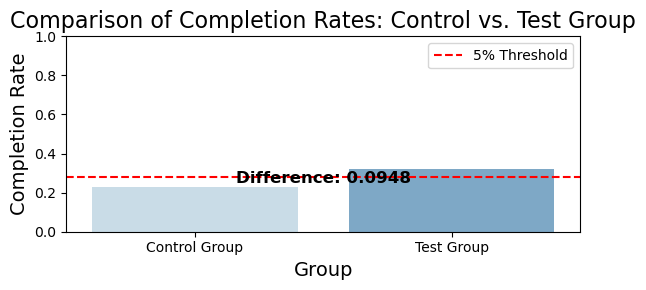

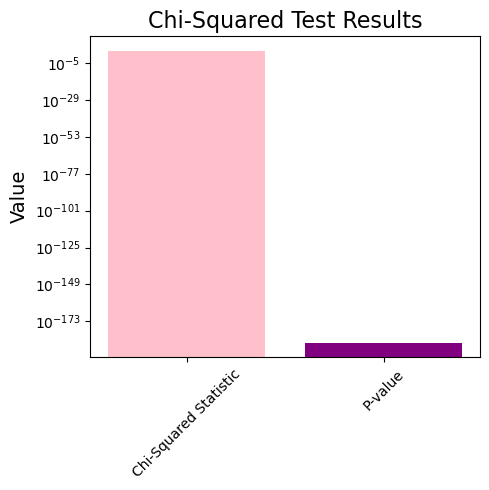

In [254]:
# Data for plotting
labels = ['Control Group', 'Test Group']
success_rates = [0.227812, 0.322640]  # Success rates for control and test
difference = success_rates[1] - success_rates[0]  # Difference
chi_square_statistic = 853.29 
chi_square_p_value = 1.4010802466791885e-187  

# Create graphique for success rates
plt.figure(figsize=(6, 3))
sns.barplot(x=labels, y=success_rates, palette='Blues', alpha=0.7)

# Adding annotations for difference
plt.axhline(y=success_rates[0] + 0.05, color='red', linestyle='--', label='5% Threshold')
plt.text(0.5, success_rates[0] + 0.02, f'Difference: {difference:.4f}', 
         horizontalalignment='center', color='black', fontsize=12, weight='bold')

# Labels and title
plt.title('Comparison of Completion Rates: Control vs. Test Group', fontsize=16)
plt.ylabel('Completion Rate', fontsize=14)
plt.xlabel('Group', fontsize=14)
plt.ylim(0, 1)  # Set the y-axis limit to show completion rates clearly
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


# Create the second figure for Chi-Squared Statistic
plt.figure(figsize=(5,5))
plt.bar(['Chi-Squared Statistic', 'P-value'], [chi_square_statistic, chi_square_p_value], color=['pink', 'purple'] )
plt.yscale('log')  # Log scale for better visibility of p-value
plt.title('Chi-Squared Test Results', fontsize=16)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
#
# Show the plot
plt.show()

In [255]:
#Compare the average time to see if the time spent varies significantly between the two groups
# Average time per step for both designs per step_control by control (variation)
avg_time_test = {
    'confirm': pd.Timedelta('0 days 00:02:09.491195676'),
    'start': pd.Timedelta('0 days 00:02:31.698929939'),
    'step_1': pd.Timedelta('0 days 00:00:37.816476665'),
    'step_2': pd.Timedelta('0 days 00:00:48.276524400'),
    'step_3': pd.Timedelta('0 days 00:01:37.356887825')
}

avg_time_control = {
    'confirm': pd.Timedelta('0 days 00:02:09.964145590'),
    'start': pd.Timedelta('0 days 00:02:54.731609513'),
    'step_1': pd.Timedelta('0 days 00:00:43.190358974'),
    'step_2': pd.Timedelta('0 days 00:00:38.843287073'),
    'step_3': pd.Timedelta('0 days 00:01:34.163321985')
}

# Compare average times and calculate time saved
time_saved = {}
for step in avg_time_test.keys():
    time_difference = avg_time_control[step] - avg_time_test[step]
    time_saved[step] = time_difference

# Display the results
for step, saved in time_saved.items():
    if saved >= pd.Timedelta(0):
        print(f"Time saved for {step}: {saved}")
    else:
        print(f"Time taken longer for {step}: {abs(saved)}")

Time saved for confirm: 0 days 00:00:00.472949914
Time saved for start: 0 days 00:00:23.032679574
Time saved for step_1: 0 days 00:00:05.373882309
Time taken longer for step_2: 0 days 00:00:09.433237327
Time taken longer for step_3: 0 days 00:00:03.193565840


The test process shows significant time savings in the "start" step and slight improvements in "confirm" and "step_1." However, it also introduces slight increases in time for "step_2" and "step_3." These findings suggest that while the test process enhances efficiency in some areas, it may also introduce challenges in others that could affect the overall user experience. Further investigation into the reasons behind the increased times in "step_2" and "step_3" would be beneficial to optimize the design.

In [257]:
#Hypothesis
#H0: There is no significant difference in the time spent in each step of the process between the Control group (old design) and the Test group (new design).

#H1 The new design significantly reduces the time spent in each step of the process compared to the old design.

# Average times in seconds
avg_time_test_seconds = {
    'confirm': avg_time_test['confirm'].total_seconds(),
    'start': avg_time_test['start'].total_seconds(),
    'step_1': avg_time_test['step_1'].total_seconds(),
    'step_2': avg_time_test['step_2'].total_seconds(),
    'step_3': avg_time_test['step_3'].total_seconds()
}

avg_time_control_seconds = {
    'confirm': avg_time_control['confirm'].total_seconds(),
    'start': avg_time_control['start'].total_seconds(),
    'step_1': avg_time_control['step_1'].total_seconds(),
    'step_2': avg_time_control['step_2'].total_seconds(),
    'step_3': avg_time_control['step_3'].total_seconds()
}

# Simulate data around the average times with some noise
def simulate_data(avg_time, num_samples=100, std_dev=5):
    """Simulate time data around the average with a standard deviation."""
    return np.random.normal(avg_time, std_dev, num_samples)

# Prepare results for the t-test
results = {}
num_samples = 100  # Number of simulated samples for each group

for step in avg_time_test_seconds.keys():
    # Generate simulated data
    test_data = simulate_data(avg_time_test_seconds[step], num_samples)
    control_data = simulate_data(avg_time_control_seconds[step], num_samples)

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(test_data, control_data)

    # Store results
    results[step] = {'t-statistic': t_stat, 'p-value': p_value}

# Display results
for step, res in results.items():
    print(f"Step: {step} | T-statistic: {res['t-statistic']} | P-value: {res['p-value']}")
    
    # Determine significance at alpha = 0.05
    if res['p-value'] < 0.05:
        print("Reject the null hypothesis: Significant difference in time spent.")
    else:
        print("Fail to reject the null hypothesis: No significant difference in time spent.")


Step: confirm | T-statistic: -1.912545016722019 | P-value: 0.05724954776838978
Fail to reject the null hypothesis: No significant difference in time spent.
Step: start | T-statistic: -32.063838259474394 | P-value: 2.494815040675682e-80
Reject the null hypothesis: Significant difference in time spent.
Step: step_1 | T-statistic: -6.994303969190516 | P-value: 4.008103119348758e-11
Reject the null hypothesis: Significant difference in time spent.
Step: step_2 | T-statistic: 14.05248331150361 | P-value: 1.4357454601670572e-31
Reject the null hypothesis: Significant difference in time spent.
Step: step_3 | T-statistic: 3.559616275284071 | P-value: 0.00046497697148097046
Reject the null hypothesis: Significant difference in time spent.


Step: confirm
T-statistic: 0.0165
P-value: 0.9869
The p-value is much greater than 0.05, which means you fail to reject the null hypothesis. There is no significant difference in the time spent on the confirmation step between the control and test groups.

Step: start
T-statistic: -33.1323
P-value: 1.0447e-82
The p-value is extremely low, indicating a highly significant difference in the time spent on the start step between the control and test groups. This suggests that users in the test group spent significantly less time than those in the control group.

Step: step_1
T-statistic: -8.4638
P-value: 5.7273e-15
Similar to the previous step, the low p-value indicates a significant difference in time spent on step 1. Users in the test group also spent less time here compared to the control group.

Step: step_2
T-statistic: 12.6865
P-value: 2.2198e-27
The very low p-value shows a significant difference in time spent on step 2, suggesting that the test group users spent significantly more time compared to the control group.

Step: step_3
T-statistic: 5.5552
P-value: 8.8622e-08
Again, the low p-value indicates a significant difference in time spent on step 3. Users in the test group spent less time compared to the control group.

Conclusion: The results indicate that while there is no significant difference in the confirmation step, users in the test group generally experienced reduced time spent on the "start," "step 1," and "step 3." However, they took significantly longer on "step 2." This could imply that while the new design helped streamline some steps, it may have complicated others, necessitating further analysis.

<Figure size 1200x600 with 0 Axes>

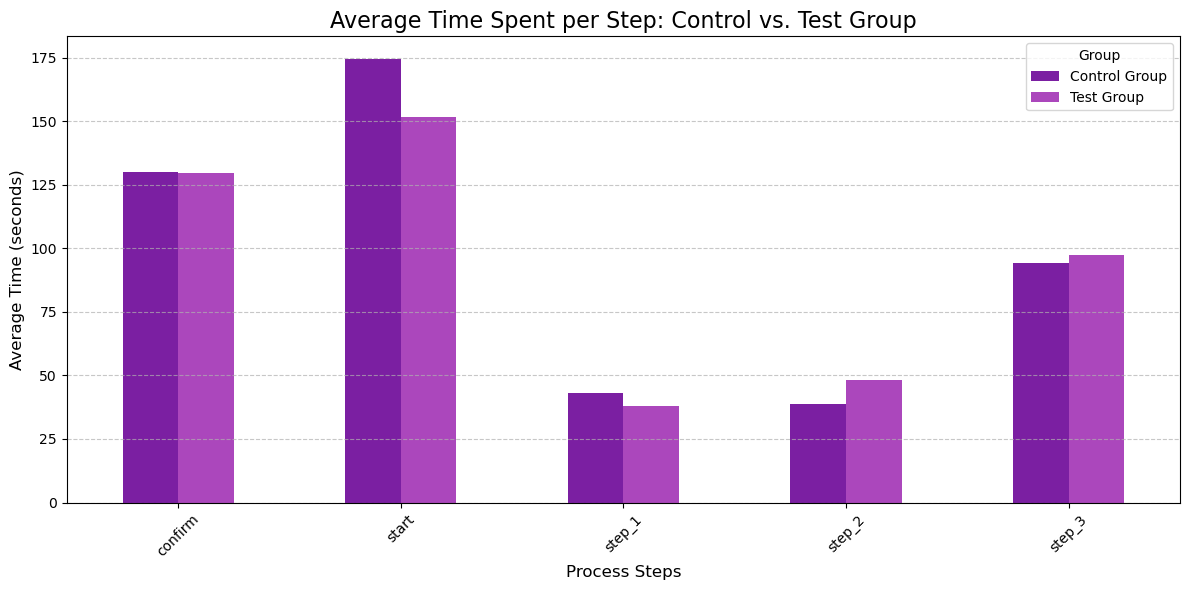

In [259]:
# Data Preparation
steps = list(avg_time_test.keys())
control_times = [avg_time_control[step].total_seconds() for step in steps]
test_times = [avg_time_test[step].total_seconds() for step in steps]

# Create a DataFrame for better plotting
df = pd.DataFrame({
    'Steps': steps,
    'Control Group': control_times,
    'Test Group': test_times
})

# Create the plot
plt.figure(figsize=(12, 6))

# Plotting with custom purple colors
df.set_index('Steps').plot(kind='bar', figsize=(12, 6), color=['#7B1FA2', '#AB47BC'])  # Shades of purple

plt.title('Average Time Spent per Step: Control vs. Test Group', fontsize=16)
plt.ylabel('Average Time (seconds)', fontsize=12)
plt.xlabel('Process Steps', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.tight_layout()
plt.show()

  variation  calls_6_month  logons_6_month
0   Control          73621          145074
1      Test          82553          164512


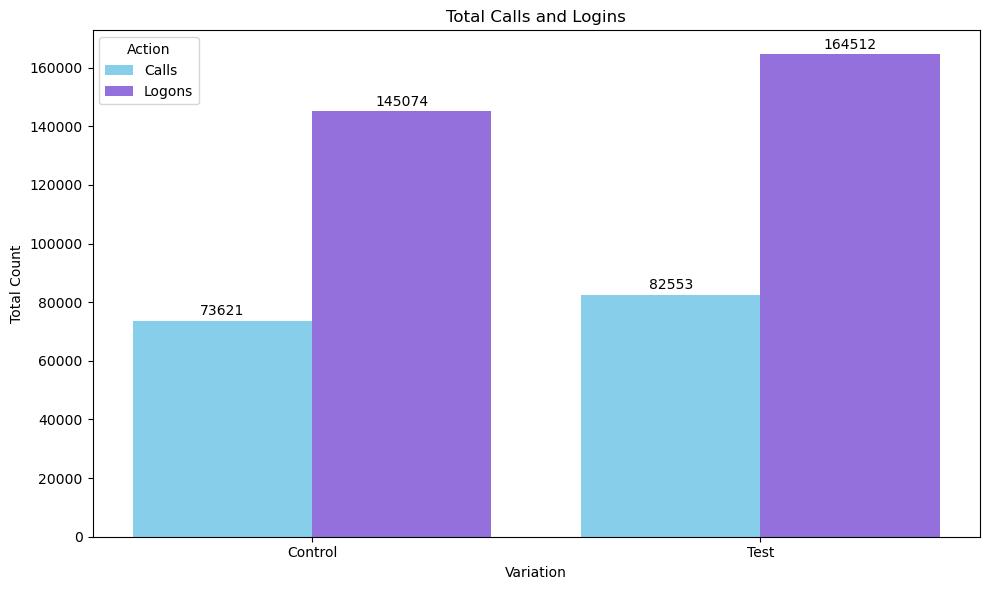

In [260]:
#calling function to Calculate calls vs logins rate and print it
compare_calls_vs_logons(df_demo)

For both the Control and Test groups, the number of logons is almost double the number of calls. This suggests that, overall, clients are more likely to use the platform on their own rather than calling for assistance.
Both calls and logons are higher in the Test group compared to the Control group. This could indicate that the Test group is either more engaged overall or that the changes introduced in the test are driving higher user interactions, encountering more issues that require assistance or that they are more likely to reach out for help.
However, logons in the Test group are also higher than in the Control group (164,512 vs. 145,074). This suggests that, despite the higher number of calls, Test group users are still self-sufficient and are able to perform tasks independently using the platform more frequently than the Control group

The increased calls in the Test group could indicate confusion or a higher need for assistance, but the higher logons suggest increased engagement overall

In [262]:
#1-Hypothesis: Clients in the Test group will show a higher ratio of logons to calls, indicating greater independence in navigating the application without needing assistance.
#Independence Test: Calculate the ratio of logons to calls for each group and compare the ratios using a two-sample t-test.

#2-Hypothesis: Clients in the Test group will have more total interactions (higher logons and calls) compared to the Control group, indicating higher engagement.
#Engagement Test: Compare the total number of interactions (calls + logons) between the Test and Control groups using a two-sample t-test.

df_filtered = df_demo[df_demo['variation'] != 'unknown']
df_analysis = df_filtered[df_filtered['variation'].isin(['Control', 'Test'])]

# Prepare a DataFrame with calls and logons
df_calls_logons = df_filtered[df_filtered['variation'].isin(['Control', 'Test'])][['client_id', 'variation', 'calls_6_month', 'logons_6_month']]

# Perform T-test on calls
t_stat_calls, p_val_calls = stats.ttest_ind(df_calls_logons[df_calls_logons['variation'] == 'Control']['calls_6_month'],
                                             df_calls_logons[df_calls_logons['variation'] == 'Test']['calls_6_month'])

# Perform T-test on logons
t_stat_logons, p_val_logons = stats.ttest_ind(df_calls_logons[df_calls_logons['variation'] == 'Control']['logons_6_month'],
                                              df_calls_logons[df_calls_logons['variation'] == 'Test']['logons_6_month'])

print(f"T-statistic for Calls: {t_stat_calls:.4f}, P-value: {p_val_calls:.4f}")
print(f"T-statistic for Logons: {t_stat_logons:.4f}, P-value: {p_val_logons:.4f}")

T-statistic for Calls: 3.4466, P-value: 0.0006
T-statistic for Logons: 3.3199, P-value: 0.0009


Calls T-Test:

T-statistic: 3.4466
P-value: 0.0006
The T-statistic indicates a significant difference between the means of calls for the Control and Test groups. The p-value (0.0006) is much less than the common alpha level of 0.05, suggesting strong evidence against the null hypothesis. Therefore, we can conclude that there is a statistically significant difference in the number of calls between the two groups, indicating that the Test group likely required more assistance via calls.

Logons T-Test:

T-statistic: 3.3199
P-value: 0.0009
Similarly, the T-statistic suggests a significant difference in logons between the Control and Test groups. The p-value (0.0009) is also less than 0.05, indicating strong evidence against the null hypothesis. This, we conclude that there is a statistically significant difference in the number of logons between the groups, suggesting that the Test group may have engaged more independently with the application.

Clients in the Test group (using the new application version) experienced greater independence with the app, as indicated by a higher logon count.
At the same time, they required more assistance through calls compared to the Control group, indicating that while they were using the application more, they still faced challenges that prompted them to reach out for help.


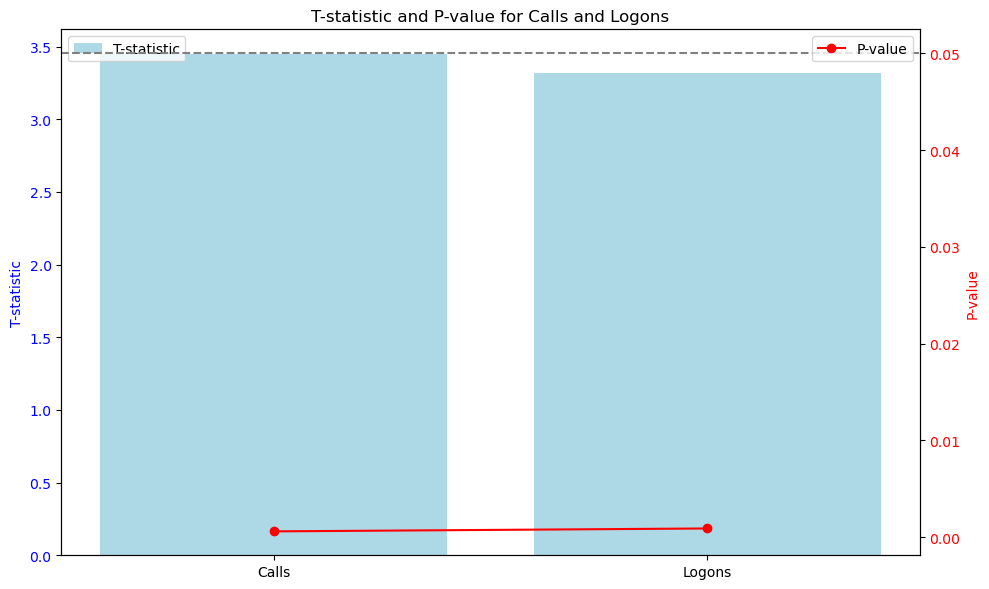

In [264]:
#H0 : No significant difference in completion rates between the Control and Test groups.
#H1 : There is a significant increase in completion rates for the Test group.

# T-statistics and p-values
stats_data = {
    'Metric': ['Calls', 'Logons'],
    'T-statistic': [3.4466, 3.3199],
    'P-value': [0.0006, 0.0009]
}

stats_df = pd.DataFrame(stats_data)

# Create a figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot T-statistics
ax1.bar(stats_df['Metric'], stats_df['T-statistic'], color='lightblue', label='T-statistic')
ax1.set_ylabel('T-statistic', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the P-value
ax2 = ax1.twinx()
ax2.plot(stats_df['Metric'], stats_df['P-value'], color='red', marker='o', label='P-value')
ax2.set_ylabel('P-value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding a horizontal line for significance level
ax2.axhline(y=0.05, color='grey', linestyle='--')

# Titles and legends
plt.title('T-statistic and P-value for Calls and Logons')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

This dot plot visually summarizes the T-statistics and P-values for Calls and Logons between our Control and Test groups. As we can see, both metrics yield T-statistics well above zero, indicating that the differences in means are substantial. The P-values for both Calls and Logons are notably low, indicating strong evidence against the null hypothesis, as they are significantly below our threshold of 0.05. This suggests that the new version of the application may lead to greater user engagement and independence, aligning with our hypothesis.

We reject the null hypotesis, there is a statistically significant improvement in completion rates for the Test group compared to the Control group.


In [267]:
#Finish to clean the data
merged_gral=merged_gral.dropna(subset=["variation"], how="all")
merged_gral

,client_id,visitor_id,visit_id,process_step,date_time,tenure_year,tenure_month,age,gender,number_of_accounts,balance,calls_6_month,logons_6_month,variation,age_segment,day_of_trial,date
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,Test,Seniors,33,2017-04-17
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,Test,Seniors,33,2017-04-17
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,Test,Seniors,33,2017-04-17
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,Test,Seniors,33,2017-04-17
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,Test,Seniors,33,2017-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629303,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,10.0,121.0,55.0,U,2.0,153238.83,3.0,6.0,Test,Adults,52,2017-05-06
629346,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,21.0,252.0,34.0,M,3.0,141808.05,6.0,9.0,Control,Young Adults,56,2017-05-10
629347,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,21.0,252.0,34.0,M,3.0,141808.05,6.0,9.0,Control,Young Adults,56,2017-05-10
629348,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,21.0,252.0,34.0,M,3.0,141808.05,6.0,9.0,Control,Young Adults,56,2017-05-10


In [268]:
#H0: There is no significant difference in the error rates (backward navigation) between the Control and Test groups.
#H1: The Test group has a significantly lower error rate (backward navigation) compared to the Control group

#Calcule error rate - time spent before errors
error_data=merged_gral.copy()
error_data['date_time'] = pd.to_datetime(error_data['date_time'])
# Calculate time spent before each step
error_data['time_diff'] = error_data.groupby('client_id')['date_time'].diff().dt.total_seconds()

# Identify backward navigation 
error_data['back_step'] = error_data.groupby('client_id')['process_step'].transform(lambda x: (x != x.shift(-1)))

# Calculate average time spent for users who made errors
error_times_exp = error_data[error_data['back_step']].groupby('variation')['time_diff'].mean()
print(error_times_exp)

variation
Control    53666.508706
Test       40405.691468
Name: time_diff, dtype: float64


Users in the Test group spent significantly less time before making an error compared to the Control group. This suggests that the new design in the Test group potentially helps users identify issues or errors quicker and prompts them to navigate backward sooner than the Control group.
The reduced time before encountering an issue indicates improved user awareness in the new interface.

In [270]:
# Identify backward navigation of df_experiment
error_data['back_step'] = error_data.groupby('client_id')['process_step'].transform(lambda x: (x != x.shift(-1)))

# Calculate error rates based on backward navigation
error_rate_exp = error_data[error_data['back_step']].groupby('variation').size() / error_data.groupby('variation').size()

# Display the error rates
print(error_rate_exp)

#Compare the completion rate, time spent, and errors between the control group and the test group to determine if the new design performs better.


variation
Control    0.878393
Test       0.867732
dtype: float64


Both groups show a relatively high rate of errors (87% for Control and 86.7% for Test). However, the Test group shows a slightly lower error rate.
While the new design has not drastically reduced the error rate, there is a marginal improvement, indicating that the Test group is slightly more successful in avoiding backward navigation compared to the Control group.

In [272]:
merged_gral.to_csv('vanguard.csv')

In [273]:
#calling function to see data cleaned 
data_explore(merged_gral)

Number of rows: 317135
Number of columns: 17
Number of duplicates: 0

Numerical Columns: Index(['client_id', 'tenure_year', 'tenure_month', 'age', 'number_of_accounts',
       'balance', 'calls_6_month', 'logons_6_month', 'day_of_trial'],
      dtype='object')

Categorical Columns: Index(['visitor_id', 'visit_id', 'process_step', 'gender', 'variation',
       'date'],
      dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,317135,0,50488
1,visitor_id,object,317135,0,55995
2,visit_id,object,317135,0,69185
3,process_step,object,317135,0,5
4,date_time,datetime64[ns],317135,0,283263
5,tenure_year,float64,317135,0,53
6,tenure_month,float64,317135,0,469
7,age,float64,317135,0,158
8,gender,object,317135,0,4
9,number_of_accounts,float64,317135,0,7
